# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [104]:
# Load the libraries as required.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [105]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [106]:
X = fires_dt.drop(columns=['area'])
Y = fires_dt['area']

In [107]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [108]:
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.drop(columns = num_cols).columns

In [109]:
preproc1 = ColumnTransformer(
    [
        ('numeric_simple', StandardScaler(), num_cols),
        ('cat_simple', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [110]:
X_train.describe()

,coord_x,coord_y,ffmc,dmc,dc,isi,temp,rh,wind,rain
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,4.661017,4.322034,90.533414,112.178692,549.813075,8.773123,18.887167,44.554479,3.997094,0.021792
std,2.294222,1.208957,5.953240,65.814101,249.214533,3.897980,5.790388,16.590003,1.783362,0.321721
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.900000,0.000000
25%,3.000000,4.000000,90.200000,70.800000,437.700000,6.400000,15.500000,32.000000,2.700000,0.000000
50%,4.000000,4.000000,91.600000,108.400000,664.500000,8.400000,19.100000,42.000000,4.000000,0.000000
75%,7.000000,5.000000,92.900000,142.400000,715.100000,10.600000,22.800000,53.000000,5.400000,0.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,22.700000,33.300000,100.000000,9.400000,6.400000


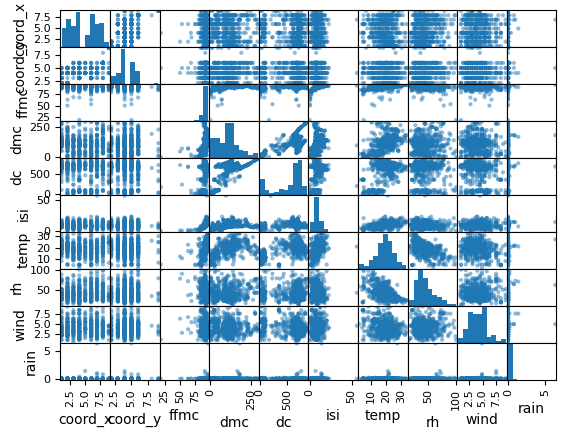

In [111]:
pd.plotting.scatter_matrix(X, diagonal='hist');

The column rh is right-skewed. Apply a log transform to that column to induce a more normal distribution.

In [112]:
non_lin_cols = ['rh']
num_cols_simple = np.setdiff1d(num_cols.values, non_lin_cols)
preproc2_num_pipe = Pipeline([
    ('log_transform', FunctionTransformer(func = lambda x: np.log1p(x), feature_names_out='one-to-one')),
    ('standardizer', StandardScaler())
])

preproc2 = ColumnTransformer([
    ('numeric_simple', StandardScaler(), num_cols_simple),
    ('numeric_nonlin', preproc2_num_pipe, non_lin_cols),
    ('cat_simple', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [113]:
# Pipeline A = preproc1 + baseline
pipeline_a = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', Ridge())
])

In [114]:
# Pipeline B = preproc2 + baseline
pipeline_b = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', Ridge())
])

In [115]:
# Pipeline C = preproc1 + advanced model
pipeline_c = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', BaggingRegressor(estimator=DecisionTreeRegressor()))
])

In [116]:
# Pipeline D = preproc2 + advanced model
pipeline_d = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', BaggingRegressor(estimator=DecisionTreeRegressor()))
])
    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [117]:
pipeline_d.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('numeric_simple', StandardScaler(),
                                    array(['coord_x', 'coord_y', 'dc', 'dmc', 'ffmc', 'isi', 'rain', 'temp',
          'wind'], dtype=object)),
                                   ('numeric_nonlin',
                                    Pipeline(steps=[('log_transform',
                                                     FunctionTransformer(feature_names_out='one-to-one',
                                                                         func=<function <lambda> at 0x0000023137173060>)),
                                                    ('standardizer',
                                                     StandardScaler())]),
                                    ['rh']),
                                   ('cat_simple',
                                    OneHotEncoder(handle_unknown='ignore'),
                          

In [118]:
scoring = ['neg_root_mean_squared_error']

In [119]:
param_grid_ridge = {
    'regressor__alpha': [0.5,1,7,20, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 10_000],
    'regressor__random_state': [42]
}

param_grid_bagging = {
    'regressor__estimator': [DecisionTreeRegressor()],
    'regressor__n_estimators': [10,15,25, 40, 50, 75, 100],
    'regressor__max_features': [0.2, 0.3, 0.5, 1.0],
    'regressor__bootstrap_features': [False, True],
    'regressor__estimator__max_depth': [None, 3, 8],
    'regressor__estimator__max_features': [3, 5, 8, 10],
    'regressor__random_state': [42]
}

In [120]:
grid_cv_a = GridSearchCV(
    estimator=pipeline_a,
    param_grid=param_grid_ridge,
    scoring=scoring,
    cv=5,
    refit=scoring[0]
)
grid_cv_a.fit(X_train,Y_train);

In [121]:
res_a = grid_cv_a.cv_results_
res_a = pd.DataFrame(res_a)
res_a = res_a.sort_values('mean_test_neg_root_mean_squared_error', ascending=False).reset_index()
res_a.to_csv('../../05_src/data/fires/cv_results/pipeline_a_cv_results.csv')

In [122]:
grid_cv_b = GridSearchCV(
    estimator=pipeline_b,
    param_grid=param_grid_ridge,
    scoring=scoring,
    cv=5,
    refit=scoring[0]
)
grid_cv_b.fit(X_train,Y_train);

In [123]:
res_b = grid_cv_b.cv_results_
res_b = pd.DataFrame(res_b)
res_b = res_b.sort_values('mean_test_neg_root_mean_squared_error', ascending=False).reset_index()
res_b.to_csv('../../05_src/data/fires/cv_results/pipeline_b_cv_results.csv')

In [124]:
grid_cv_c = GridSearchCV(
    estimator=pipeline_c,
    param_grid=param_grid_bagging,
    scoring=scoring,
    cv=5,
    refit=scoring[0]
)
grid_cv_c.fit(X_train,Y_train);

In [125]:
res_c = grid_cv_c.cv_results_
res_c = pd.DataFrame(res_c)
res_c = res_c.sort_values('mean_test_neg_root_mean_squared_error', ascending=False).reset_index()
res_c.to_csv('../../05_src/data/fires/cv_results/pipeline_c_cv_results.csv')

In [126]:
grid_cv_d = GridSearchCV(
    estimator=pipeline_d,
    param_grid=param_grid_bagging,
    scoring=scoring,
    cv=5,
    refit=scoring[0]
)
grid_cv_d.fit(X_train,Y_train);

In [127]:
res_d = grid_cv_d.cv_results_
res_d = pd.DataFrame(res_d)
res_d = res_d.sort_values('mean_test_neg_root_mean_squared_error', ascending=False).reset_index()
res_d.to_csv('../../05_src/data/fires/cv_results/pipeline_d_cv_results.csv')

In [128]:
print('best pipeline_a mean RMSE: ' + str(np.abs(res_a['mean_test_neg_root_mean_squared_error'][0])))
print('best pipeline_b mean RMSE: ' + str(np.abs(res_b['mean_test_neg_root_mean_squared_error'][0])))
print('best pipeline_c mean RMSE: ' + str(np.abs(res_c['mean_test_neg_root_mean_squared_error'][0])))
print('best pipeline_d mean RMSE: ' + str(np.abs(res_d['mean_test_neg_root_mean_squared_error'][0])))

best pipeline_a mean RMSE: 38.46519104980907
best pipeline_b mean RMSE: 38.47050133138956
best pipeline_c mean RMSE: 39.23910930317373
best pipeline_d mean RMSE: 39.085680562220865


# Evaluate

+ Which model has the best performance?

The baseline ridge regression with no non-linear transformation performed the best. The specific parameters of this pipeline are:

In [129]:
grid_cv_a.best_params_

{'regressor__alpha': 2000, 'regressor__random_state': 42}

# Export

+ Save the best performing model to a pickle file.

In [130]:
import pickle
with open('../../05_src/fires/best_fire_estimator.pkl', 'wb') as f:
    pickle.dump(grid_cv_a.best_estimator_, f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [131]:
best_lin_regressor = grid_cv_a.best_estimator_.named_steps['regressor']
coef_df = pd.DataFrame(best_lin_regressor.coef_, columns=['coef']).set_index(preproc1.fit(X_train).get_feature_names_out())
coef_df = coef_df.sort_values(by='coef', key=abs, ascending=False)
coef_df

,coef
numeric_simple__dmc,0.802701
numeric_simple__coord_x,0.747910
numeric_simple__temp,0.645753
numeric_simple__coord_y,0.437850
numeric_simple__rh,-0.404827
numeric_simple__ffmc,0.242526
numeric_simple__dc,0.231178
cat_simple__day_thu,0.179213
cat_simple__day_fri,-0.151172
numeric_simple__isi,0.148409


Since the best regressor was a linear model, which can be explained well by the coefficients, I start with that analysis. Of note, the features dmc, x_coord, and temp were the most important features to the best ridge regressor.

In [132]:
import shap
best_pipeline = grid_cv_a.best_estimator_
data_transform = best_pipeline.named_steps['preprocessing'].transform(X_test)

explainer = shap.explainers.Linear(
    best_pipeline.named_steps['regressor'], 
    data_transform,
    feature_names = best_pipeline.named_steps['preprocessing'].get_feature_names_out())

shap_values = explainer(data_transform)

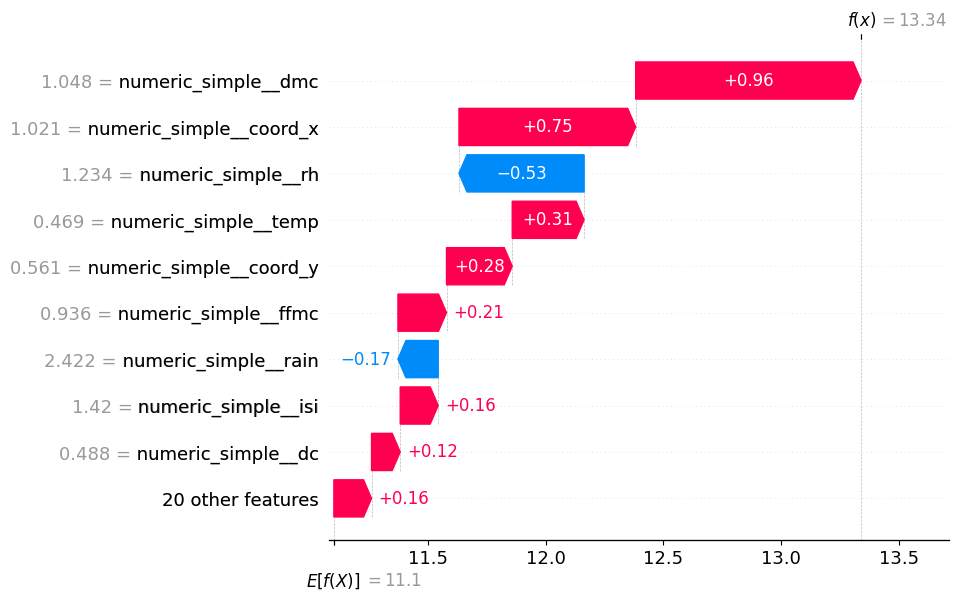

In [133]:
shap.plots.waterfall(shap_values[1])

In [134]:
obs0_shap = pd.DataFrame(shap_values.values[0],columns=['shap_values']).set_index(preproc1.fit(X_train).get_feature_names_out())
obs0_shap = obs0_shap.sort_values(by='shap_values', key=abs,ascending=False)
obs0_shap

,shap_values
numeric_simple__rh,-1.240141
numeric_simple__dmc,-0.911902
numeric_simple__temp,-0.844683
numeric_simple__coord_x,0.424311
numeric_simple__dc,-0.395817
numeric_simple__coord_y,0.279211
numeric_simple__isi,-0.250255
numeric_simple__ffmc,-0.242361
cat_simple__day_sat,0.078815
numeric_simple__wind,0.066240


For observation 0, rh, dmc, and temp were the most important features by SHAP value. Overall by SHAP value, dmc, coord_x, and rh were the most important features. Interestingly, rh ranked ahead of temp and coord_y by SHAP value, despite having a ridge regression coefficient of lesser magnitude.

I would remove the categorical features day and month. In the initial data exploration, I noted that none of those would be represented well in any of the ~100 sample cross validation test sets, so the training was likely to be noisy. Furthermore, they contributed greatly to dimensionality increase following the One Hot Encoding. Finally, in terms of both SHAP value and ridge coefficient, they appeared to be inconsequential. The presence of these features, and the assumption that the instructions forbade dropping them, led me to choose a ridge regression and include high alpha values in the grid search. This would give the linear regression the best chance of suppressing their presence.

I would remove the categorical variables month and day, then refit the pipelines. Assuming that change would not have significantly degraded model performance on training data, I would evaluate on testing data.

Note that the target variable, area, had a high concentration of values at or very close to 0, with scattered much larger observations. In another setting, I would propose reframing this problem as a classification problem to predict fires of area larger or smaller than some threshold.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.